In [ ]:
!pip install imbalanced-learn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve,auc
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
df = pd.read_csv('/content/power_marketing_dataset_preprocessed.csv')




In [ ]:
# Step 1: 타깃을 이진 분류로 변환 (상위 30%는 High, 나머지는 Low)
threshold = df["Target"].quantile(0.70)
df["Label"] = df["Target"].apply(lambda x: 1 if x >= threshold else 0)

# 클래스 분포 확인
df["Label"].value_counts()

,count
Label,
0,700
1,300


In [ ]:
#smote 알고리즘 적용 전

X = df.drop(columns=["Target", "Label"])
y = df["Label"]


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 성능 저장용 리스트
precision_list = []
recall_list = []
f1_list = []
accuracy_list = []

'''
누적을 사용하는 이유는 kfold 방식을 사용하기 때문에
모든 fold를 반영하여 전체적인 성능을 평가하는 것이 일반적인 방법임
'''

# confusion matrix 누적용
conf_matrix_sum = None

for train_idx, test_idx in skf.split(X, y):
    X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
    y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

    # 모델 학습
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train_fold, y_train_fold)

    # 예측
    y_pred_fold = rf.predict(X_test_fold)

    # 점수 계산
    report = classification_report(y_test_fold, y_pred_fold, output_dict=True)
    precision_list.append(report['macro avg']['precision'])
    recall_list.append(report['macro avg']['recall'])
    f1_list.append(report['macro avg']['f1-score'])
    accuracy_list.append(accuracy_score(y_test_fold, y_pred_fold))

    cm = confusion_matrix(y_test_fold, y_pred_fold)
    if conf_matrix_sum is None:
      conf_matrix_sum = cm
    else:
      conf_matrix_sum += cm

# 평균 출력
print("Average Scores over 5 folds:")
print(f"Precision (macro): {np.mean(precision_list):.4f}")
print(f"Recall (macro):    {np.mean(recall_list):.4f}")
print(f"F1-score (macro):  {np.mean(f1_list):.4f}")
print(f"Accuracy:          {np.mean(accuracy_list):.4f}")
print("Total Confusion Matrix over 5 folds:")
print(conf_matrix_sum)

Average Scores over 5 folds:
Precision (macro): 0.6654
Recall (macro):    0.6500
F1-score (macro):  0.6542
Accuracy:          0.7220
Total Confusion Matrix over 5 folds:
[[581 119]
 [159 141]]


- score 개선하기 위한 방법*  
1.하이퍼 파라미터 설정  
2.임계값 조정   
3.smote 알고리즘 사용   


In [ ]:

# 하이퍼파라미터 그리드 정의
param_grid = {
    'rf__n_estimators': [200, 300],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_split': [5, 7],
    'rf__min_samples_leaf': [2, 3]
}

# 파이프라인 구성
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42))
])

# StratifiedKFold 기반 GridSearch
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1,
    verbose=1,
    return_train_score=False
)

# GridSearch 수행
grid_search.fit(X, y)

# 최적 모델
best_model = grid_search.best_estimator_

# 결과 출력
print("\n Best Parameters:")
print(grid_search.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits

 Best Parameters:
{'rf__max_depth': 10, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 5, 'rf__n_estimators': 200}


Average Scores over 5 folds (with threshold optimization):
Precision (macro): 0.7549
Recall (macro):    0.8029
F1-score (macro):  0.7486
Accuracy:          0.7600

Average Feature Importances:
                                 Feature  Importance
14          Incentive Participation_True    0.453032
3                 Peak Consumption (kWh)    0.062738
0                                    Age    0.058405
6   Consumption by Time of Day (Evening)    0.058337
7                        Engagement Rate    0.058024
4                  Avg Consumption (kWh)    0.050141
2              Monthly Consumption (kWh)    0.049087
5   Consumption by Time of Day (Morning)    0.046019
1                         Household Size    0.034419
12            Marketing Interaction_True    0.032252
13                Pricing Plan_Flat Rate    0.032058
10                        Location_Loc_4    0.018385
11                        Location_Loc_5    0.018010
8                         Location_Loc_2    0.016735
9           

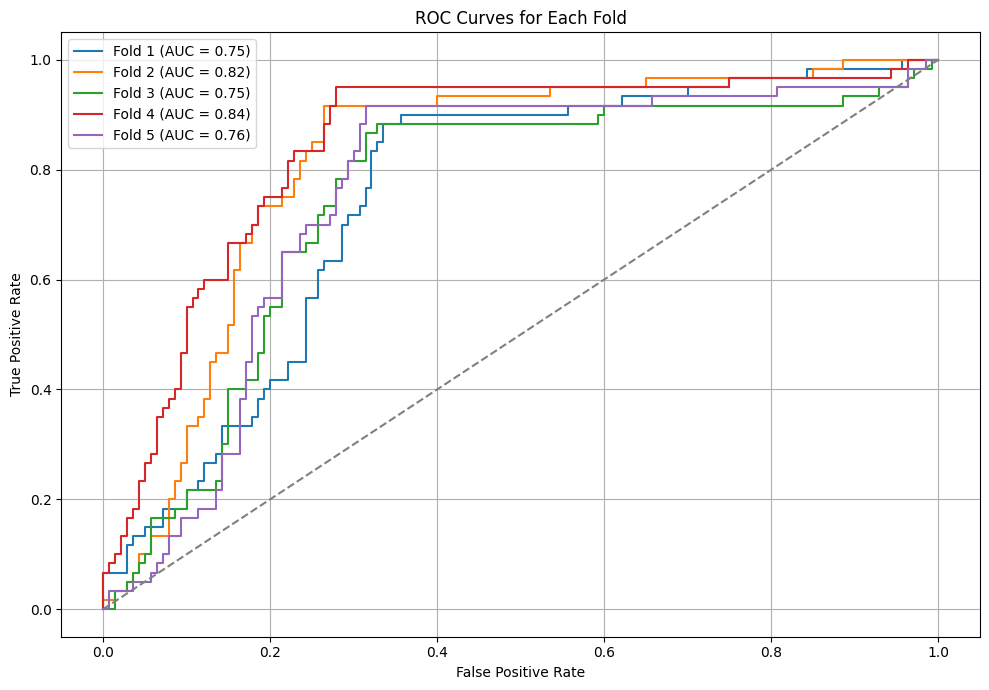

In [ ]:
# smote 알고리즘 적용
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

precision_list = []
recall_list = []
f1_list = []
accuracy_list = []
feature_importances = []
conf_matrix_sum = None
y_test_list = []
y_proba_list = []

for train_idx, test_idx in skf.split(X, y):
    X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
    y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train_fold, y_train_fold)

    rf = RandomForestClassifier(
        random_state=42,
        max_depth=10,
        min_samples_leaf=2,
        min_samples_split=5,
        n_estimators=200
    )
    rf.fit(X_resampled, y_resampled)

    y_proba = rf.predict_proba(X_test_fold)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test_fold, y_proba)
    best_threshold = thresholds[np.argmax(tpr - fpr)]
    y_pred_fold = (y_proba >= best_threshold).astype(int)

    report = classification_report(y_test_fold, y_pred_fold, output_dict=True)
    precision_list.append(report['macro avg']['precision'])
    recall_list.append(report['macro avg']['recall'])
    f1_list.append(report['macro avg']['f1-score'])
    accuracy_list.append(accuracy_score(y_test_fold, y_pred_fold))
    feature_importances.append(rf.feature_importances_)

    cm = confusion_matrix(y_test_fold, y_pred_fold)
    conf_matrix_sum = cm if conf_matrix_sum is None else conf_matrix_sum + cm

    y_test_list.append(y_test_fold)
    y_proba_list.append(y_proba)

# 평균 중요도
mean_importances = np.mean(feature_importances, axis=0)
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': mean_importances
}).sort_values(by='Importance', ascending=False)

# 결과 출력
print("Average Scores over 5 folds (with threshold optimization):")
print(f"Precision (macro): {np.mean(precision_list):.4f}")
print(f"Recall (macro):    {np.mean(recall_list):.4f}")
print(f"F1-score (macro):  {np.mean(f1_list):.4f}")
print(f"Accuracy:          {np.mean(accuracy_list):.4f}")

print("\nAverage Feature Importances:")
print(importance_df)
print("\nTotal Confusion Matrix over 5 folds:")
print(conf_matrix_sum)

# ROC Curve 시각화
plt.figure(figsize=(10, 7))
for i in range(len(y_test_list)):
    fpr, tpr, _ = roc_curve(y_test_list[i], y_proba_list[i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Fold {i+1} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curves for Each Fold')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
#decision tree algorithm
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
smote = SMOTE(random_state=42)

conf_matrix_sum = None
reports = []

for train_idx, test_idx in skf.split(X, y):
    X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
    y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

    # SMOTE 적용
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train_fold, y_train_fold)

    # 결정 트리 학습
    dt = DecisionTreeClassifier(random_state=42, max_depth=10, min_samples_leaf=2, min_samples_split=5)
    dt.fit(X_resampled, y_resampled)

    y_proba = dt.predict_proba(X_test_fold)[:, 1]

    # 최적 threshold 계산 (각 fold마다 다른 임계치 적용)
    fpr, tpr, thresholds = roc_curve(y_test_fold, y_proba)
    best_threshold = thresholds[np.argmax(tpr - fpr)]

    # threshold 적용
    y_pred_fold = (y_proba >= best_threshold).astype(int)

    # confusion matrix 누적
    cm = confusion_matrix(y_test_fold, y_pred_fold)
    if conf_matrix_sum is None:
        conf_matrix_sum = cm
    else:
        conf_matrix_sum += cm

    # classification report 저장
    report = classification_report(y_test_fold, y_pred_fold, output_dict=True)
    reports.append(report)

# 각 지표 평균 계산
avg_precision = np.mean([r['macro avg']['precision'] for r in reports])
avg_recall = np.mean([r['macro avg']['recall'] for r in reports])
avg_f1 = np.mean([r['macro avg']['f1-score'] for r in reports])
avg_accuracy = np.mean([r['accuracy'] for r in reports])

# 출력
print("Confusion Matrix (SMOTE + Decision Tree):")
print(conf_matrix_sum)

print("\nPerformance Metrics (macro average):")
print(f"Accuracy:  {avg_accuracy:.4f}")
print(f"Precision: {avg_precision:.4f}")
print(f"Recall:    {avg_recall:.4f}")
print(f"F1-score:  {avg_f1:.4f}")

Confusion Matrix (SMOTE + Decision Tree):
[[519 181]
 [ 95 205]]

Performance Metrics (macro average):
Accuracy:  0.7240
Precision: 0.6898
Recall:    0.7124
F1-score:  0.6939
